In [1]:
import re
import os
import json
import glob
import pickle
from decimal import Decimal

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn import tree

from utils import get_feature_number, get_targets, get_features


model_dir = "models"
image_dir = "images"
data_dir = "data"
log_dir = "logs"

if not os.path.exists(model_dir) : os.mkdir(model_dir)
if not os.path.exists(image_dir) : os.mkdir(image_dir)

# Load in dictionary mapping human readable labels to each feature name and target. 
with open(os.path.join(data_dir, "human_readable_labels_features.json"), 'rb') as f:
    readable_features_map = json.load(f)


train_df = pd.read_csv(os.path.join(data_dir, "train_31_vars.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test_31_vars.csv"))


X_subset_features_28 = [str(i) for i in range(31) if i !=28]
X_subset_features_29 = [str(i) for i in range(31) if i !=29]
X_subset_features_30 = [str(i) for i in range(30)]

# Extract different training sets. 
X_train_subset_28, X_train_subset_28_df, X_train_subset_feature_28_names = get_features(train_df, X_subset_features_28)
X_train_subset_29, X_train_subset_29_df, X_train_subset_feature_29_names = get_features(train_df, X_subset_features_29)
X_train_subset_30, X_train_subset_30_df, X_train_subset_30_feature_names = get_features(train_df, X_subset_features_30)


X_train_subset_28_df_renamed = X_train_subset_28_df.rename(columns=readable_features_map)
X_train_subset_29_df_renamed = X_train_subset_29_df.rename(columns=readable_features_map)
X_train_subset_30_df_renamed = X_train_subset_30_df.rename(columns=readable_features_map)


y_train_28, y_train_28_df, class_names_28= get_targets(
    train_df, 
    readable_features_map,
    target='28'
)


y_train_29, y_train_29_df, class_names_29= get_targets(
    train_df, 
    readable_features_map,
    target='29'
)
                        
y_train_30, y_train_30_df, class_names_30= get_targets(
    train_df, 
    readable_features_map,
    target='30'
) 



# Extract different training sets. 
X_test_subset_28, X_test_subset_28_df, X_test_subset_feature_28_names = get_features(test_df, X_subset_features_28)
X_test_subset_29, X_test_subset_29_df, X_test_subset_feature_29_names = get_features(test_df, X_subset_features_29)
X_test_subset_30, X_test_subset_30_df, X_test_subset_30_feature_names = get_features(test_df, X_subset_features_30)

X_test_subset_28_df_renamed = X_test_subset_28_df.rename(columns=readable_features_map)
X_test_subset_29_df_renamed = X_test_subset_29_df.rename(columns=readable_features_map)
X_test_subset_30_df_renamed = X_test_subset_30_df.rename(columns=readable_features_map)



y_test_28, y_test_28_df, class_names_28= get_targets(
    test_df, 
    readable_features_map,
    target='28'
)

y_test_29, y_test_29_df, class_names_29= get_targets(
    test_df, 
    readable_features_map,
    target='29'
)

y_test_30, y_test_30_df, class_names_30= get_targets(
    test_df, 
    readable_features_map,
    target='30'
)

In [2]:
def get_macro_f1_scores(X_test, y_test, log_dir, training_seeds, target_number, grid_search_log_str, sampler):
    '''
    Extracts cross-validation measures from grid search and evaluates best model (according to logs) on test set. 
    params:
        X_test (NumPy array): Matrix containing feature matrix (independent variables).
        y_test (NumPy array): Array with target feature (dependent variable). 
        log_dir (str): Log direcory containing grid-search results/details cross-validation files. 
        training_seeds (NumPy array): Array with random seeds used in training. 
        target_number (str): Number in the feature name of the target variable. 

    return: 
        best_model (str): String indicating the best model ('nb', 'lr' or 'dt')
        results_dict (dict): Dictionary containing evaluations over validation sets and test sets. 
    
    '''
    with open(os.path.join(log_dir, grid_search_log_str.format(target_number)), 'rb') as f:
        log = json.load(f)
    best_model= log["best_model"]
    print(best_model)
    val_f1_df = pd.read_csv(os.path.join(log_dir, "target_target_{}_{}_{}_grid_search_cross_val.csv".format(
            target_number,
            best_model, 
            sampler
            )
        )
    )
    # We need [0] because otherwise we return a list containing only the mean validation score. 
    val_mean_f1 =  val_f1_df[val_f1_df["rank_test_score"]==1]["mean_test_score"].values[0] 
    val_std_f1  = val_f1_df[val_f1_df["rank_test_score"]==1]["std_test_score"].values[0]
    print("best_model", best_model)
    # Naive Bayes performs deterministically so we don't have different random seeds. 
    if best_model == 'nb':
        # Load in classifier for best model for this specific target. 
        clf = pickle.load(open(os.path.join(model_dir, "target_{}_{}_{}.pickle".format(target_number, best_model, sampler)), 'rb'))
        # Predictions on test set. 
        test_preds = clf.predict(X_test)
        # Macro F1 score calculated on test set. 
        test_f1 = f1_score(y_test, test_preds, average='macro')
        test_precision = precision_score(y_test, test_preds, average='macro')
        test_recall = recall_score(y_test, test_preds, average='macro')
        cm = confusion_matrix(y_test, test_preds)
        # Get mean/std over cross-validation scores and just a single test score (no different random seeds).
        results_dict =   {
            "val_mean_f1": val_mean_f1,
            "val_std_f1":val_std_f1, 
            "test_f1":test_f1,
            "test_precision": test_precision, 
            "test_recall": test_recall,
            "confusion_matrix" : cm
            
            
        } 
    else:
        # Collect test scores over training different seeds. 
        test_f1_scores= []
        test_precision_scores=[]
        test_recall_scores=[]
        cms = []
        for seed in training_seeds:
            # Load classifier for given target, best model and training seed. 
            clf = pickle.load(
                open(
                    os.path.join(model_dir, "target_{}_{}_seed_{}_{}.pickle".format(target_number, best_model, seed, sampler)), 'rb')
            )
            # Predict test set examples. 
            test_preds = clf.predict(X_test)
            # Macro f1 on test set. 
            test_f1 = f1_score(y_test, test_preds, average='macro')
            test_precision = precision_score(y_test, test_preds, average='macro')
            test_recall = recall_score(y_test, test_preds, average='macro')
            cm = confusion_matrix(y_test, test_preds)
            # Add to test scores list. 
            test_f1_scores.append(test_f1) 
            test_precision_scores.append(test_precision)
            test_recall_scores.append(test_recall)
            cms.append(cm)
        # Caclulate mean and standard deviation over test scores. 
        test_mean_f1 = np.mean(test_f1_scores) 
        test_std_f1  = np.std(test_f1_scores)
        test_mean_precision = np.mean(test_precision_scores)
        test_std_precision = np.std(test_precision_scores)
        test_mean_recall = np.mean(test_recall_scores)
        test_std_recall = np.std(test_recall_scores)
        # Get mean/std over cross-validation scores and the mean/std over training seeds. 
        results_dict = {
            "val_mean_f1": val_mean_f1,
            "val_std_f1":val_std_f1, 
            "test_mean_f1":test_mean_f1, 
            "test_std_f1":test_std_f1,
            "test_mean_precision": test_mean_precision, 
            "test_std_precision": test_std_precision,
            "test_mean_recall": test_mean_recall, 
            "test_std_recall": test_std_recall,
            "confusion_matrices": cms
        } 
    # Return best model as a string and the relevant results dictionary. 
    return best_model, results_dict

best_logs = dict()
for i in [28, 29, 30]:
    logs = sorted(glob.glob(os.path.join(log_dir, "target_{}*.json".format(i))))
    best_scores = []
    for filename in logs: 

        with open(filename) as f:
            grid_search_dict  = json.load(f)
        best_scores.append(grid_search_dict["best_score_overall"])
    best_model_log= logs[np.argmax(best_scores)]
    best_logs[i] = {"best_log": best_model_log.split(os.sep)[-1], "sampler":re.search("[0-9]+_(.*)_grid", best_model_log).group(1)}
    


# Load the random seeds used for training. 
training_seeds = pd.read_csv("random_seeds.csv")["seeds"].values
# Get results for each feature subset and target. 
best_model_28 , results_dict_28 = get_macro_f1_scores(
    X_test_subset_28, 
    y_test_28, 
    log_dir, 
    training_seeds, 
    "28", 
    best_logs[28]["best_log"],
    best_logs[28]["sampler"]
)
best_model_29 , results_dict_29 = get_macro_f1_scores(
    X_test_subset_29, 
    y_test_29, 
    log_dir, 
    training_seeds, 
    "29", 
    best_logs[29]["best_log"],
    best_logs[29]["sampler"]
)
best_model_30 , results_dict_30 = get_macro_f1_scores(
    X_test_subset_30, 
    y_test_30, 
    log_dir, 
    training_seeds, 
    "30",
    best_logs[30]["best_log"],
    best_logs[30]["sampler"]
)


print("28", best_model_28, best_logs[28]["best_log"], best_logs[28]["sampler"])
print("29", best_model_29,best_logs[29]["best_log"], best_logs[29]["sampler"])
print("30", best_model_30,best_logs[30]["best_log"], best_logs[30]["sampler"])



dt
best_model dt
dt
best_model dt
lr
best_model lr
28 dt target_28_random_over_sampling_grid_search_results.json random_over_sampling
29 dt target_29_random_over_sampling_grid_search_results.json random_over_sampling
30 lr target_30_random_over_sampling_grid_search_results.json random_over_sampling


In [3]:
# What features are used in each model: Order for targets -  43, 26, 27, 30
X_column_print = [
    "subset", 
    "subset", 
    "subset"
]
# Readable names for targets.
y_column_print = [
    "28. Tackler head placement",
    "29. Body region struck on tackler",
    "30. Body region struck on BC"
    ]
# Model that produced best performance during cross-validation. 
best_models_print = [
    best_model_28,
    best_model_29,
    best_model_30
]
val_mean_f1s = [
    results_dict_28["val_mean_f1"], 
    results_dict_29["val_mean_f1"], 
    results_dict_30["val_mean_f1"]
]
val_std_f1s = [
    results_dict_28["val_std_f1"], 
    results_dict_29["val_std_f1"],
    results_dict_30["val_std_f1"]
]
# We don't have a mean/standard deviation test score as naive bayes is deterministic over random initialisations. 
test_mean_f1s = [
    results_dict_28["test_mean_f1"], 
    results_dict_29["test_mean_f1"], 
    results_dict_30["test_mean_f1"]
]
test_std_f1s = [
    results_dict_28["test_std_f1"], 
    results_dict_29["test_std_f1"],  
    results_dict_30["test_std_f1"]
]

test_mean_precision = [
    results_dict_28["test_mean_precision"], 
    results_dict_29["test_mean_precision"], 
    results_dict_30["test_mean_precision"]
]
test_std_precision = [
    results_dict_28["test_std_precision"], 
     results_dict_29["test_std_precision"], 
    results_dict_30["test_std_precision"]
]
test_mean_recall = [
    results_dict_28["test_mean_recall"], 
    results_dict_29["test_mean_recall"], 
    results_dict_30["test_mean_recall"]
]
test_std_recall = [
    results_dict_28["test_std_recall"], 
    results_dict_29["test_std_recall"], 
    results_dict_30["test_std_recall"]
]
# Create overall results dataframe. 
results_df = pd.DataFrame()
results_df["Features"] = X_column_print
results_df["Best Model"] = best_models_print
results_df["Target"] = y_column_print
# TODO! Double check the floating point rounding here. 
results_df["Validation Macro F1 Mean (std)"] = ['{:.3f} ({:e})'.format(i, j) for i, j in zip(val_mean_f1s , val_std_f1s)] 
results_df["Test Macro F1 Mean (std)"] = ['{:.3f} ({:e})'.format(i, j) for i, j in zip(test_mean_f1s, test_std_f1s)]
results_df["Test Macro precision Mean (std)"] = ['{:.3f} ({:e})'.format(i, j) for i, j in zip(test_mean_precision, test_std_precision)]
results_df["Test Macro recall Mean (std)"] = ['{:.3f} ({:e})'.format(i, j) for i, j in zip(test_mean_recall, test_std_recall)]
results_df

,Features,Best Model,Target,Validation Macro F1 Mean (std),Test Macro F1 Mean (std),Test Macro precision Mean (std),Test Macro recall Mean (std)
0,subset,dt,28. Tackler head placement,0.670 (3.679612e-02),0.699 (2.220446e-16),0.681 (1.110223e-16),0.742 (1.110223e-16)
1,subset,dt,29. Body region struck on tackler,0.649 (2.123270e-02),0.640 (1.110223e-16),0.610 (1.110223e-16),0.782 (1.110223e-16)
2,subset,lr,30. Body region struck on BC,0.613 (1.600860e-02),0.546 (2.220446e-16),0.550 (0.000000e+00),0.651 (1.110223e-16)


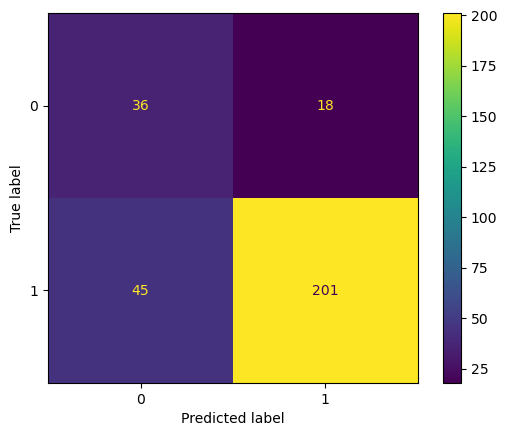

In [13]:
from sklearn.metrics import  ConfusionMatrixDisplay
random_seed = 119
seed_idx = list(training_seeds).index(119)

# Get confusion matrix
cm_28 = results_dict_28["confusion_matrices"][seed_idx]
disp_28 = ConfusionMatrixDisplay(confusion_matrix=cm_28)
disp_28.plot()
plt.savefig("images/confusion_matrix_seed_119_var_28.png")


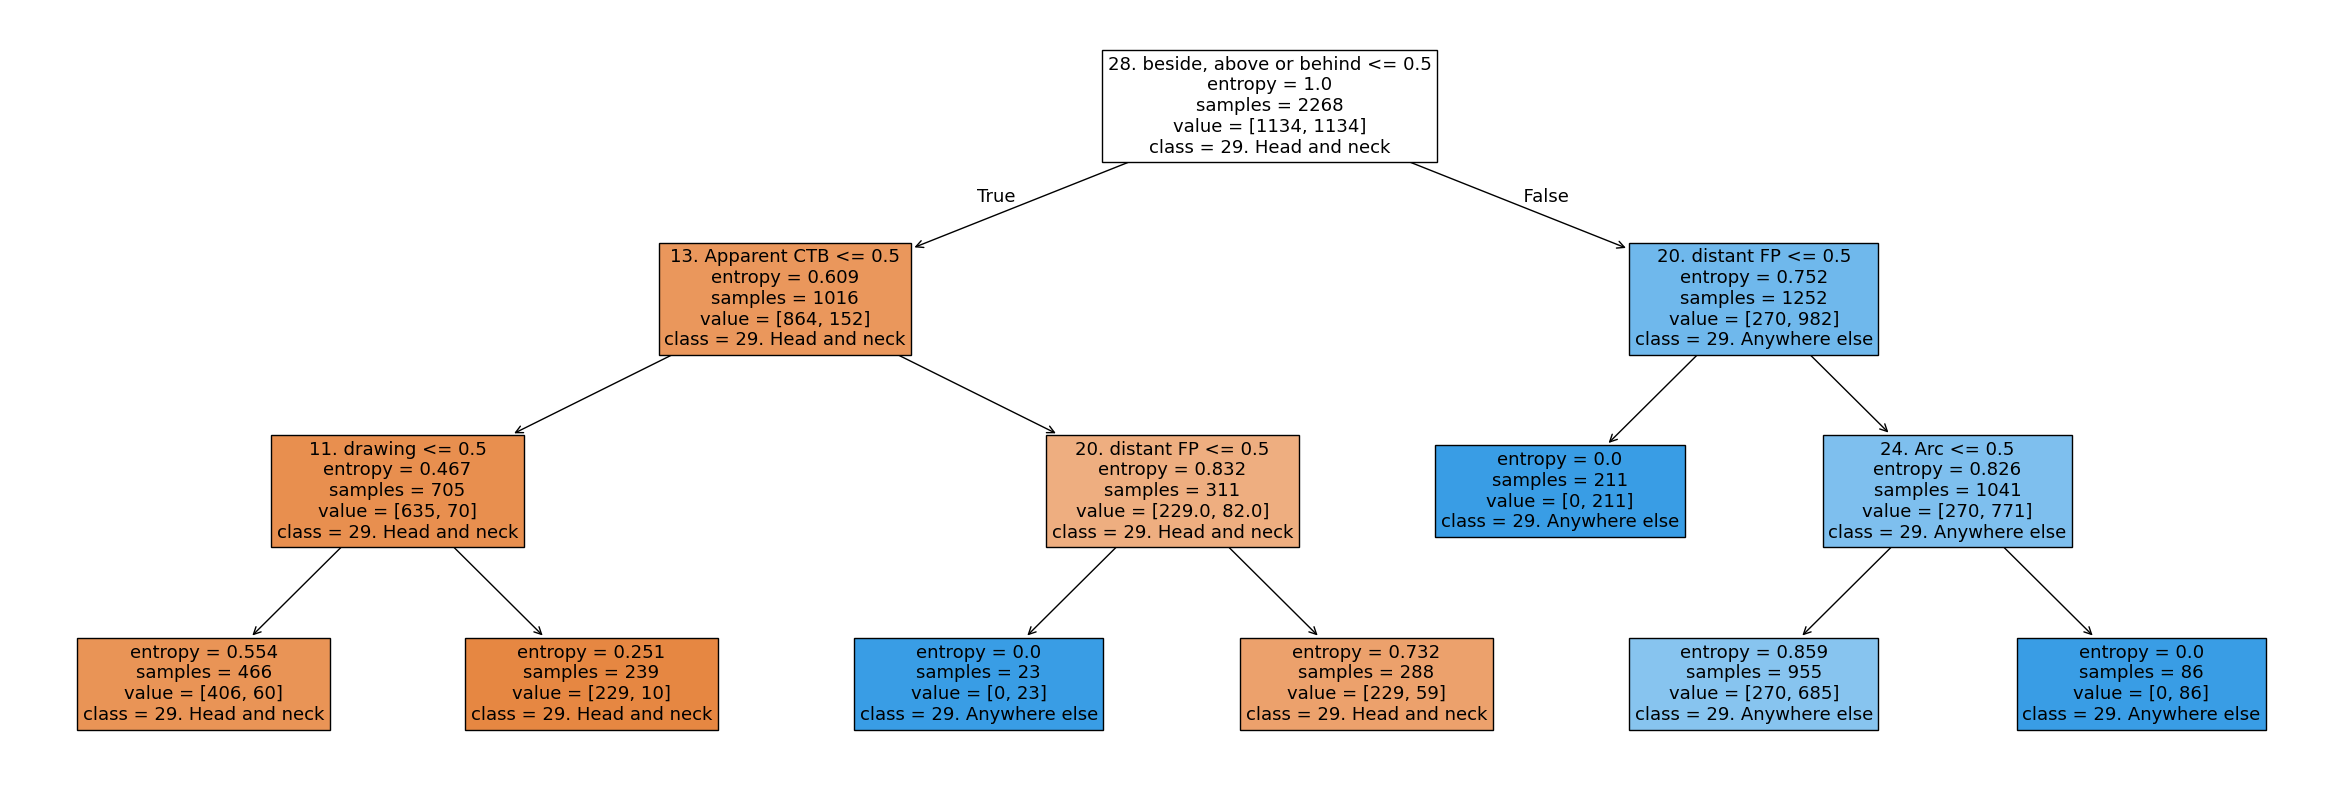

In [5]:
model_name_29 = "target_29_dt_seed_119_random_over_sampling.pickle"

plt.figure(figsize=(30, 10))
clf = pickle.load(open(os.path.join("models",model_name_29), 'rb'))
_ = tree.plot_tree(clf, 
                   feature_names=X_train_subset_29_df_renamed.columns,  
                   class_names=class_names_29,
                   filled=True,
                   fontsize=13
                  )
plt.savefig(os.path.join(image_dir, "{}.png".format(model_name_29)))

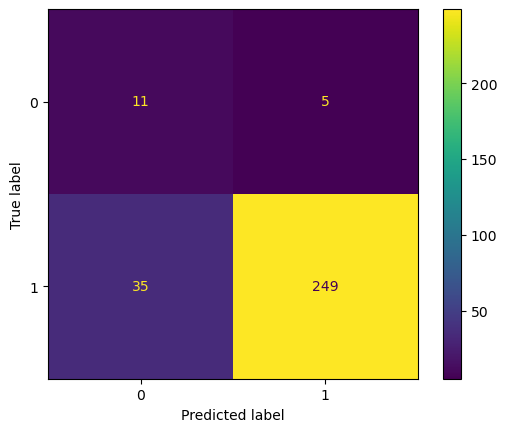

In [12]:
# Get confusion matrix
cm_29 = results_dict_29["confusion_matrices"][seed_idx]
disp_29 = ConfusionMatrixDisplay(confusion_matrix=cm_29)
disp_29.plot()
plt.savefig("images/confusion_matrix_seed_119_var_29.png")

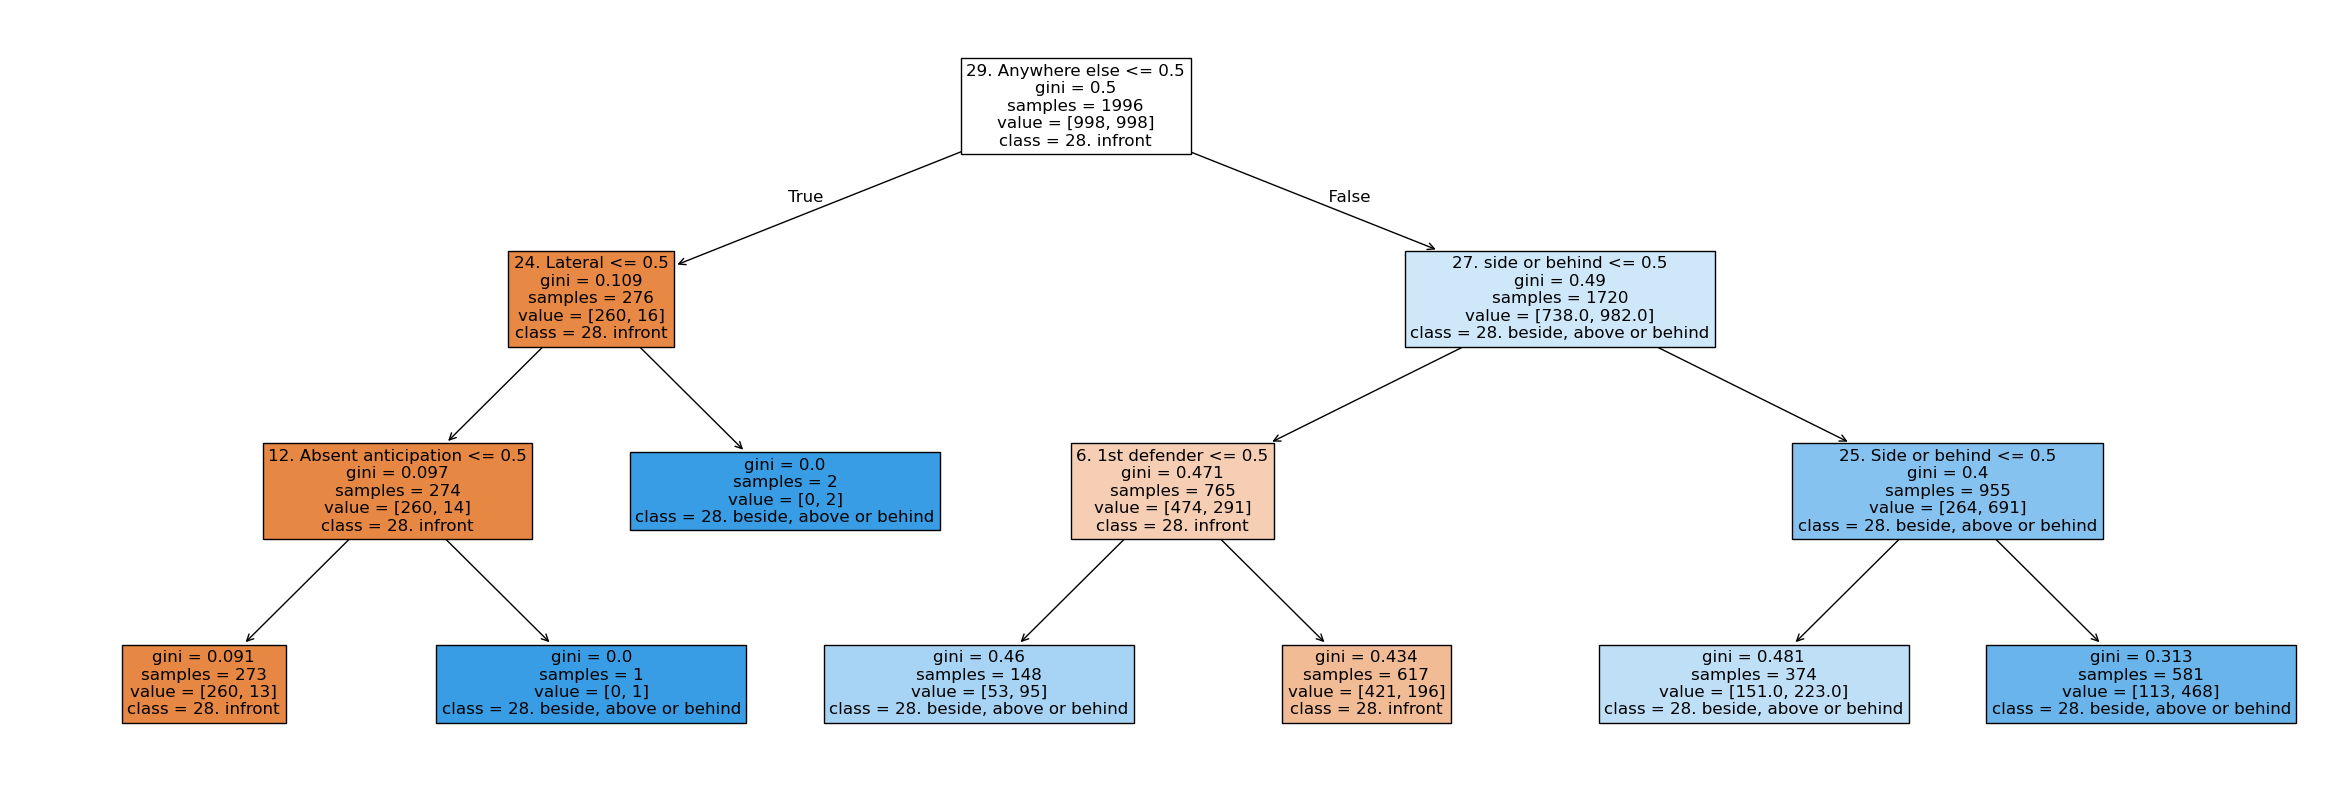

In [7]:
model_name_28 = "target_28_dt_seed_119_random_over_sampling.pickle"

plt.figure(figsize=(30, 10))
clf = pickle.load(open(os.path.join("models",model_name_28), 'rb'))
_ = tree.plot_tree(clf, 
                   feature_names=X_train_subset_28_df_renamed.columns,  
                   class_names=class_names_28,
                   filled=True,
                   fontsize=12
                  )
plt.savefig(os.path.join(image_dir, "{}.png".format(model_name_28)))

In [8]:

model_name_30 = "target_30_lr_seed_119_random_over_sampling.pickle"

ax = plt.figure(figsize=(20, 10))
clf = pickle.load(open(os.path.join("models",model_name_30), 'rb'))

# The shape the co-efficients is (1, 78) so we index into [0]
coefs = clf.coef_[0]
feature_names_30  = X_test_subset_30_df_renamed.columns
lg_30_df = pd.DataFrame()
lg_30_df.index = feature_names_30
lg_30_df["coefs"] = coefs

<Figure size 2000x1000 with 0 Axes>

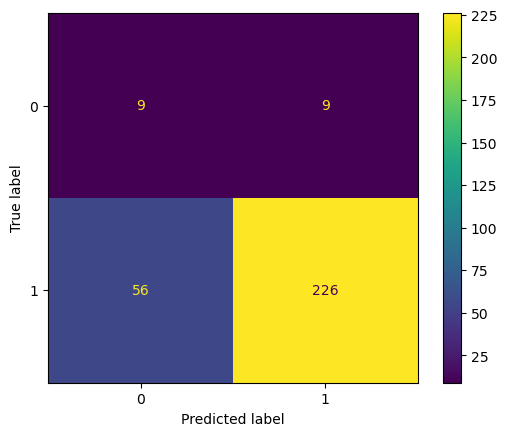

In [11]:
# Get confusion matrix
cm_30 = results_dict_30["confusion_matrices"][seed_idx]
disp_30 = ConfusionMatrixDisplay(confusion_matrix=cm_30)
disp_30.plot()
plt.savefig("images/confusion_matrix_seed_119_var_30.png")

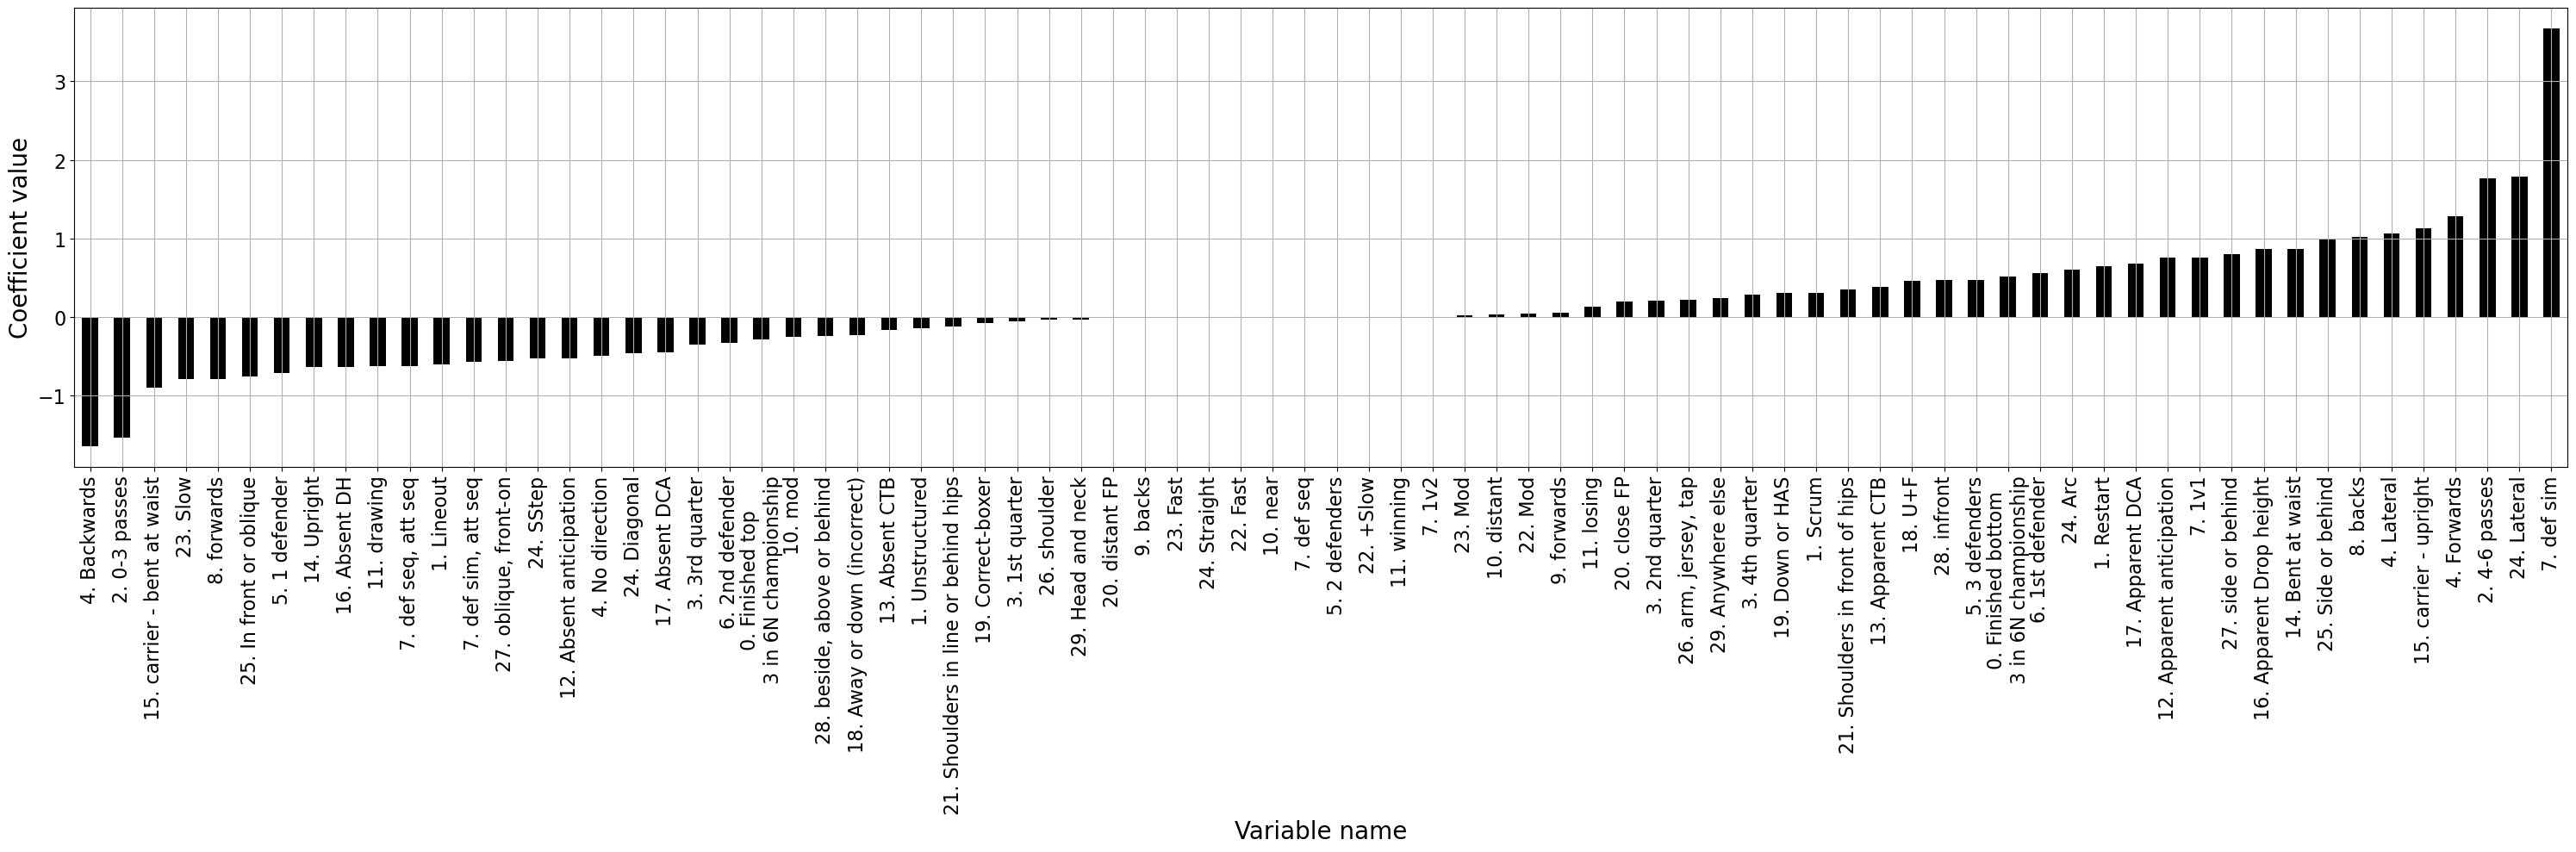

In [10]:
lg_30_df = lg_30_df.sort_values('coefs')
lg_30_df.plot(kind="bar", figsize=(30, 10), legend=False, color="black", fontsize=16)
plt.xlabel("Variable name", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(image_dir, "{}.png".format(model_name_30)), bbox_inches='tight')